# US Geological Survey Data Reader

This is a GUI-driven application that fetches information from the US Geological Survey for a specific watershed through dates specified by the user. The user inputs the start date, end date, and the 8-digit Hydrolic Unit Code (HUC) for the desired area of interest.

The code then outputs data on the average water temperature, average air temperature, average wind speed, and water discharge over the specified days. A graph is then made for each of these as well for al the specified time.

Note: Most US Geological Survey sites do not have this sort of timeseries data aailable for it. You can find more information on HUC on their website:
https://waterdata.usgs.gov/nwis/dv?referred_module=sw&search_criteria=state_cd&search_criteria=site_tp_cd&submitted_form=introduction

https://water.usgs.gov/wsc/map_index.html

https://water.usgs.gov/wsc/findwatershed.html

The code below was run with the sample input: 

3/5/2021 3/15/2021 08048000

Note that all input dates must be in this format, with spaces between each entry.

In [4]:
from suds.client import Client
import tkinter as tk
import sys
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from sympy import *
init_printing()

W Fk Trinity Rv at Ft Worth, TX


,Average Water Temp (Celsius),Average Air Temp (Fahrenheit),Average Wind Speed (mph),Average Discharge (feet cubed per second),Average Water Temp (Fahrenheit)
Date,,,,,
2021-03-11,16.967708,72.947917,5.865625,41.583333,62.541875
2021-03-12,17.709375,72.862500,4.938542,75.179167,63.876875
2021-03-13,18.156250,71.112500,5.730208,92.328125,64.681250
2021-03-14,18.366304,64.550000,5.729348,90.273913,65.059348
2021-03-15,18.395833,66.104167,5.314583,51.843750,65.112500


,Average Water Temp (Celsius),Average Air Temp (Fahrenheit),Average Wind Speed (mph),Average Discharge (feet cubed per second),Average Water Temp (Fahrenheit)
0,16.432795,64.784981,5.046863,55.495342,61.57903


Rows with NaN values:


,Water Temp (Celsius),Air Temp (Fahrenheit),Wind Speed (mph),Discharge,Water Temp (Fahrenheit)
Date,,,,,


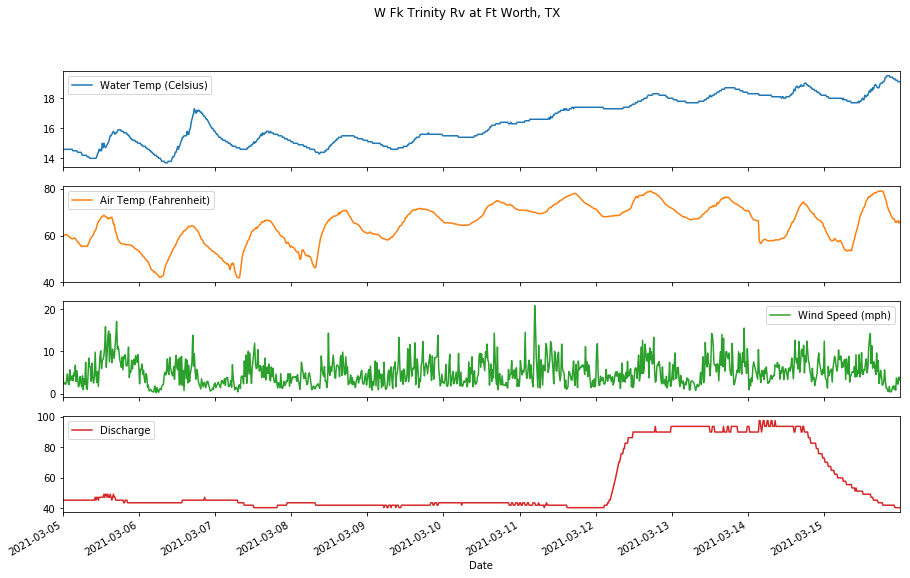

In [15]:
#sample input to copy and paste 3/5/2021 3/15/2021 08048000
wsdlURL = 'http://hydroportal.cuahsi.org/nwisuv/cuahsi_1_1.asmx?WSDL'
siteCode = 'NWISUV:'
variableCodes = ['NWISUV:00010', 'NWISUV:00021', 'NWISUV:00035', 'NWISUV:00060']
beginDate = ''
endDate = ''


def clicked():
    global siteCode
    global beginDate
    global endDate
    info = ent.get()
    info_array = info.split()
    siteCode = siteCode + info_array[2]
    beginDate = datetime.datetime.strptime(info_array[0], '%m/%d/%Y').strftime('%Y-%m-%d')
    endDate = datetime.datetime.strptime(info_array[1], '%m/%d/%Y').strftime('%Y-%m-%d')
    window.destroy()

    
window = tk.Tk()
window.title("Hydrology App")

#initial height
lab = tk.Label(window, text = "Start/End Date and Site Number: ").grid(column=0, row=0)
ent = tk.Entry(window, width=30)
ent.grid(column=1, row=0)

button = tk.Button(window, text = "Enter", command = clicked)
button.grid(column=0,row=1)


window.mainloop()

#create a new object named 'NWIS' for caling we service methods
NWIS = Client(wsdlURL).service

# Call the GetSiteInfoObject method
response = NWIS.GetSiteInfoObject(siteCode)

# Get the site's name from the response
siteName = response.site[0].siteInfo.siteName
print(siteName)


dates = []
measurements = []

#call GetValuesObject method to get data, every 15 min
for variableCode in variableCodes:
    response = NWIS.GetValuesObject(siteCode, variableCode, beginDate, endDate)

    if not(Client.dict(response)['timeSeries'][0]):
        sys.exit()

    try:
        getattr( response.timeSeries[0].values[0] ,  'value')
    except AttributeError:
        print("No value")
    else:
        values = response.timeSeries[0].values[0].value
    
        myDataValues=[]
        myDates=[]
        for v in values:
            myDataValues.append(float(v.value))
            myDates.append(v._dateTime)
            
        dates.append(myDates)
        measurements.append(myDataValues)
        

#create the DataFrame
c = np.column_stack((measurements[0], measurements[1], measurements[2], measurements[3], dates[0]))
df = pd.DataFrame(c, columns = ['Water Temp (Celsius)', 'Air Temp (Fahrenheit)', 'Wind Speed (mph)', 'Discharge', 'Date'])
df.index = df['Date']
del df['Date']
df['Water Temp (Fahrenheit)'] = 1.8*df['Water Temp (Celsius)'] + 32


#daily averages for all the values

#create a range of dates to loop through
date_range = pd.date_range(start=beginDate, end=endDate)

average_value_data = []

#loop through all the days, and get the average value of each variable
for days in date_range:
    test = []
    day = df[days.strftime('%Y-%m-%d'):days.strftime('%Y-%m-%d')]
    test.append(days)
    test.append(day['Water Temp (Celsius)'].mean())
    test.append(day['Air Temp (Fahrenheit)'].mean())
    test.append(day['Wind Speed (mph)'].mean())
    test.append(day['Discharge'].mean())
    test.append(day['Water Temp (Fahrenheit)'].mean())
    average_value_data.append(test)

#create dataframe object to store all the values
average_df = pd.DataFrame(average_value_data, columns = ['Date', 'Average Water Temp (Celsius)', 'Average Air Temp (Fahrenheit)', 'Average Wind Speed (mph)', 'Average Discharge (feet cubed per second)', 'Average Water Temp (Fahrenheit)'])
average_df.index = average_df['Date']
del average_df['Date']

#assignment asks only the tail to be displayed
daily_averages = average_df.tail()
#daily_averages




#overall averages for all the values
total_averages = []
total_averages.append(df['Water Temp (Celsius)'].mean())
total_averages.append(df['Air Temp (Fahrenheit)'].mean())
total_averages.append(df['Wind Speed (mph)'].mean())
total_averages.append(df['Discharge'].mean())
total_averages.append(df['Water Temp (Fahrenheit)'].mean())
total_averages
overall_averages = pd.DataFrame([total_averages], columns = ['Average Water Temp (Celsius)', 'Average Air Temp (Fahrenheit)', 'Average Wind Speed (mph)', 'Average Discharge (feet cubed per second)', 'Average Water Temp (Fahrenheit)'])
#overall_averages




is_NaN = df.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = df[row_has_NaN]
with_NaN = rows_with_NaN.tail()

#print(rows_with_NaN)



%matplotlib inline
df.plot(y=['Water Temp (Celsius)', 'Air Temp (Fahrenheit)', 'Wind Speed (mph)', 'Discharge'], subplots=True, figsize=(15,9), title = siteName)

display(daily_averages)
display(overall_averages)
print('Rows with NaN values:')
display(with_NaN)


The code above was executed with the following input:
    
    3/5/2021 3/15/2021 08048000